## Imports

In [ ]:
import os
from sklearn import metrics
import time
import torch
import torchvision

## Device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Paths

In [ ]:
training_data_directory = "../grouped-data/train/"
testing_data_directory = "../grouped-data/test/"
model_directory = "./models/"
image_name_list_path = "./xview2.txt"

## Load Data

In [ ]:
def get_first_n_lines(filename, n):
    with open(filename, "r") as file:
        wanted_image_names = set(next(file).strip() for _ in range(n))

    subset_indices = []
    for idx, img_data in enumerate(training_data.imgs):
        if img_data[0].split("/")[-1] in wanted_image_names:
            subset_indices.append(idx)
            if len(subset_indices) == n:
                break  # Stop the loop once we have found n matches

    return torch.utils.data.DataLoader(
        torch.utils.data.Subset(training_data, subset_indices),
        batch_size=12,
        shuffle=True,
        num_workers=8,
    )


training_data = torchvision.datasets.ImageFolder(
    training_data_directory,
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
)


training_data_loaders = [
    get_first_n_lines(image_name_list_path, n) for n in [1,2]
]

testing_data = torchvision.datasets.ImageFolder(
    testing_data_directory,
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
)
testing_data_loader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=12,
    shuffle=False,
    num_workers=8,
)

## Dataset Size

In [ ]:
for training_data_loader in training_data_loaders:
    print("Training dataset size:", len(training_data_loader.dataset))
print("Testing dataset size:", len(testing_data_loader.dataset))

Training dataset size: 1
Testing dataset size: 933
Training dataset size: 2
Testing dataset size: 933


## Train Model

In [ ]:
def format_duration(seconds):
    # Calculate the time components
    components = [
        ("w", seconds // 604800),  # 1 week is 604800 seconds
        ("d", seconds // 86400 % 7),  # 1 day is 86400 seconds
        ("h", seconds // 3600 % 24),  # 1 hour is 3600 seconds
        ("min", seconds // 60 % 60),  # 1 minute is 60 seconds
        ("s", round(seconds % 60, 2)),
    ]

    # Only include non-zero components
    components = [(label, value) for label, value in components if value > 0]

    # Format the string
    return ", ".join(f"{value}{label}" for label, value in components)


def print_phase_info(is_training, total_loss, correct_prediction_count):
    dataset_length = len(
        training_data_loader.dataset if is_training else testing_data_loader.dataset
    )
    print(
        "    {} Epoch {} done. Loss: {:.2f}, Accuracy: {:.2f}%, Phase Duration: {}, Total Duration: {}".format(
            "Training" if is_training else "Testing",
            epoch,
            total_loss / dataset_length,
            (correct_prediction_count / dataset_length) * 100.0,
            format_duration(
                time.time()
                - (training_start_time if is_training else testing_start_time)
            ),
            format_duration(time.time() - start_time),
        )
    )


for i, training_data_loader in enumerate(training_data_loaders):
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    input_feature_count = model.fc.in_features
    output_feature_count = 5
    model.fc = torch.nn.Linear(input_feature_count, output_feature_count)
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    epoch_count = 1
    start_time = time.time()
    for epoch in range(epoch_count):
        epoch_start_time = time.time()
        print("Epoch {} running.".format(epoch))
        """ Training Phase """
        training_start_time = time.time()
        model.train()
        total_loss = 0.0
        correct_prediction_count = 0
        for inputs, targets in training_data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Foward pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = criterion(outputs, targets)

            # Back-propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            correct_prediction_count += torch.sum(predictions == targets.data)
        print_phase_info(True, total_loss, correct_prediction_count)

        """ Testing Phase """
        testing_start_time = time.time()
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            correct_prediction_count = 0
            for inputs, targets in testing_data_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                loss = criterion(outputs, targets)

                total_loss += loss.item() * inputs.size(0)
                correct_prediction_count += torch.sum(predictions == targets.data)
            print_phase_info(False, total_loss, correct_prediction_count)

        print(
            "Epoch {} done. Epoch Duration: {}, Total Duration: {}".format(
                epoch,
                format_duration(time.time() - epoch_start_time),
                format_duration(time.time() - start_time),
            )
        )
        print("--------------------------------------------")
    torch.save(model.state_dict(), os.path.join(model_directory, str(i)))

Epoch 0 running.
    Training Epoch 0 done. Loss: 1.95, Accuracy: 0.00%, Phase Duration: 19.57s, Total Duration: 19.57s
    Testing Epoch 0 done. Loss: 1.84, Accuracy: 14.15%, Phase Duration: 1.0min, 37.19s, Total Duration: 1.0min, 56.76s
Epoch 0 done. Epoch Duration: 1.0min, 56.77s, Total Duration: 1.0min, 56.77s
--------------------------------------------
Epoch 0 running.
    Training Epoch 0 done. Loss: 1.31, Accuracy: 0.00%, Phase Duration: 20.67s, Total Duration: 20.67s
    Testing Epoch 0 done. Loss: 1.66, Accuracy: 23.90%, Phase Duration: 1.0min, 37.52s, Total Duration: 1.0min, 58.19s
Epoch 0 done. Epoch Duration: 1.0min, 58.19s, Total Duration: 1.0min, 58.19s
--------------------------------------------


## Create Confusion Matrix

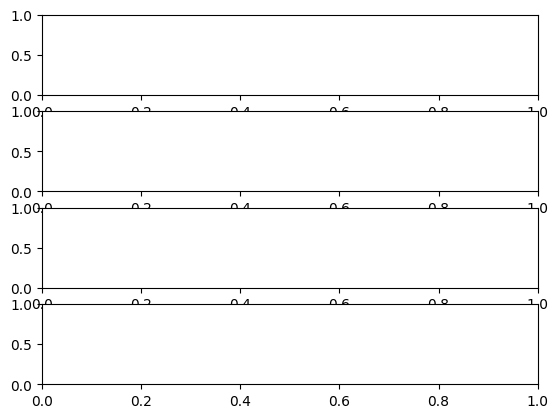

In [ ]:

confusion_matrices = []
for i, model_filename in enumerate(os.listdir(model_directory)):
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    input_feature_count = model.fc.in_features
    output_feature_count = 5
    model.fc = torch.nn.Linear(input_feature_count, output_feature_count)
    model.load_state_dict(torch.load(os.path.join(model_directory, model_filename)))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        inputs, targets = next(
            iter(
                torch.utils.data.DataLoader(
                    testing_data,
                    batch_size=len(testing_data),
                )
            )
        )
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        confusion_matrix = metrics.confusion_matrix(targets, predictions.cpu())
        confusion_matrices.append(confusion_matrix)

## Show Confusion Matrix

Overall accuracy 0: 14.15%
Average accuracy 0: 19.15%
Overall accuracy 1: 23.90%
Average accuracy 1: 22.23%


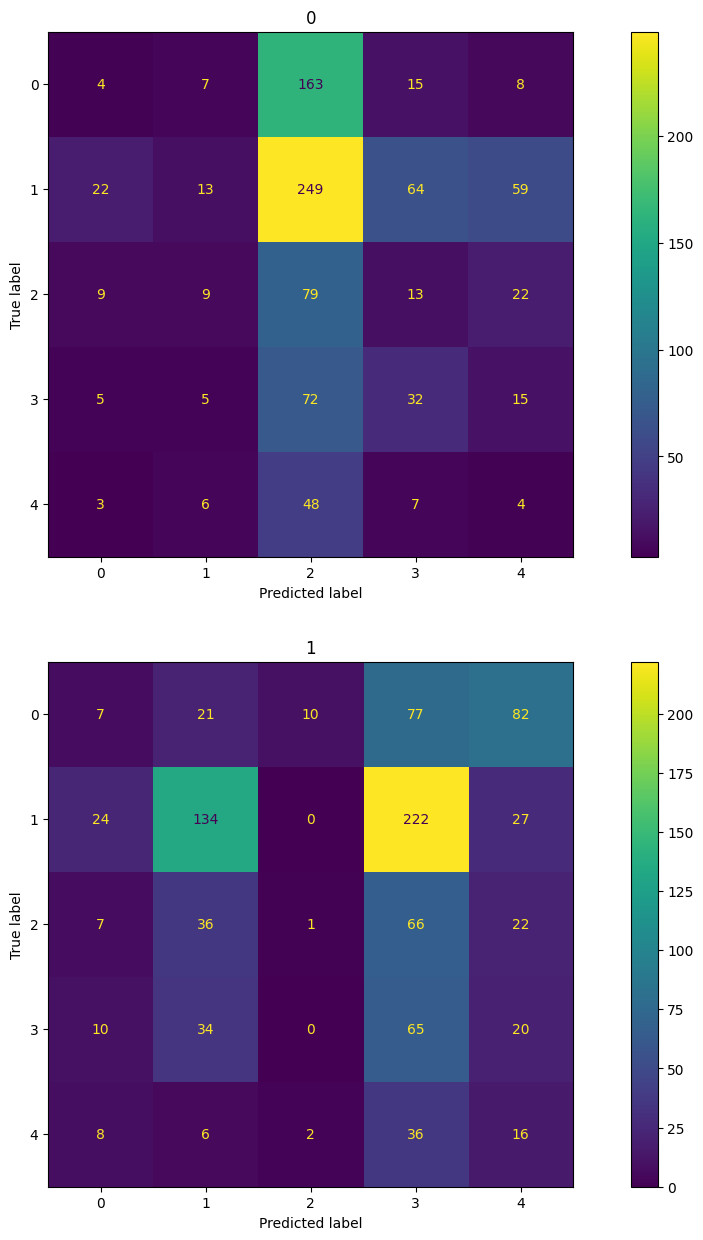

In [21]:
import matplotlib.pyplot as pyplot
fig, axs = pyplot.subplots(2, figsize=(15, 15))
for i, confusion_matrix in enumerate(confusion_matrices):
    overall_accuracy = confusion_matrix.trace() / confusion_matrix.sum()
    average_accuracy = (
        confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)
    ).mean()
    confusion_matrix_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix
    )
    confusion_matrix_display.plot(ax=axs[i])
    axs[i].set_title(i)

    print("Overall accuracy {}: {:.2f}%".format(i, overall_accuracy * 100))
    print("Average accuracy {}: {:.2f}%".format(i, average_accuracy * 100))

pyplot.show()